In [35]:
import torch

"""
torch LSTM 预测 特斯拉 股票

date [TSLA.csv] from
    https://finance.yahoo.com/quote/TSLA/history
    https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1517443200&period2=1675245633&interval=1d&events=history&includeAdjustedClose=true
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch import nn

In [36]:
base4 = ['Open', 'High', 'Low', 'Close']

df = pd.read_csv("./TSLA.csv", index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-01,23.400000,23.977333,23.242001,23.283333,23.283333,62965500.0
2018-02-02,23.229334,23.463333,22.700666,22.916668,22.916668,55572000.0
2018-02-05,22.531334,22.964666,22.200001,22.208668,22.208668,66961500.0
2018-02-06,21.680668,22.414667,21.566668,22.264668,22.264668,76326000.0
2018-02-07,22.599333,23.066668,22.377333,23.000000,23.000000,104538000.0
...,...,...,...,...,...,...
2023-01-25,141.910004,146.410004,138.070007,144.429993,144.429993,192734300.0
2023-01-26,159.970001,161.419998,154.759995,160.270004,160.270004,234815100.0
2023-01-27,162.429993,180.679993,161.169998,177.899994,177.899994,305632100.0


In [37]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,133.723498,136.831237,130.288272,133.614927,133.614927,1.341028e+08
std,117.277183,119.927006,114.249598,117.090092,117.090092,9.044132e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,21.076668,21.496000,20.644667,21.081333,21.081333,7.615350e+07
50%,100.896667,103.333336,98.073997,100.871330,100.871330,1.034727e+08
75%,235.666672,239.996674,231.369995,236.163330,236.163330,1.598835e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [38]:
df = df.fillna(method='ffill')  # 缺失值填充，使用上一个有效值
np.sum(df.isnull())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2018-02-01 to 2023-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   float64
dtypes: float64(6)
memory usage: 68.8+ KB


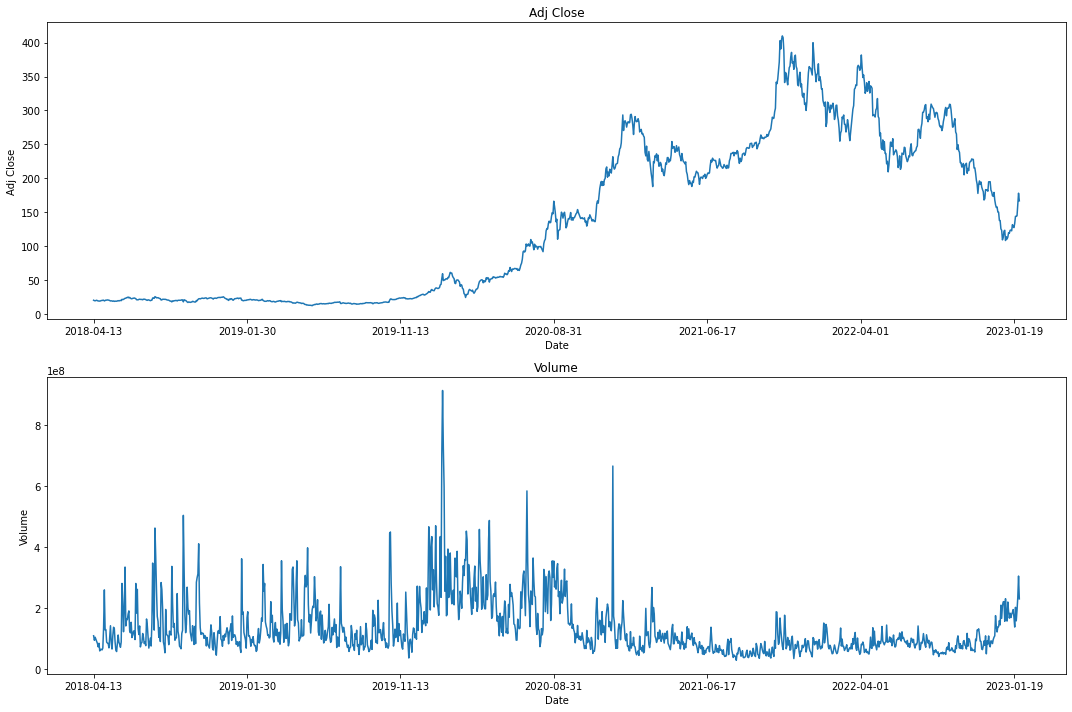

In [72]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.title("Adj Close")

plt.subplot(2, 1, 2)
df['Volume'].plot()
plt.ylabel('Volume')
plt.title("Volume")

plt.tight_layout()

In [41]:
# import seaborn as sns
# sns.pairplot(df, kind='reg')

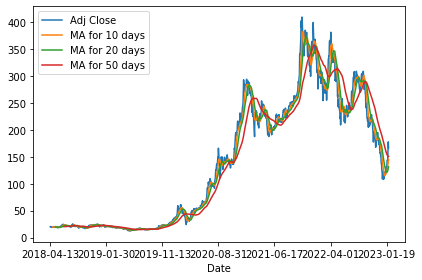

In [90]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.tight_layout()

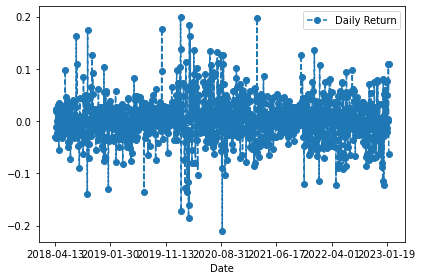

In [91]:
# 收益图
df['Daily Return'] = df['Adj Close'].pct_change()
df['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.tight_layout()

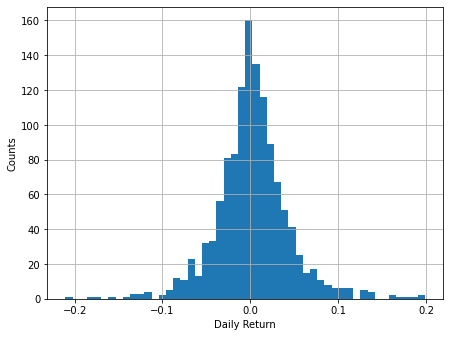

In [44]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
df['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')

plt.tight_layout()

# 开始 lstm

In [45]:
scaler = MinMaxScaler(feature_range=(-1, 1))
for col in base4:  # 这里不能进行统一进行缩放，因为fit_transform返回值是numpy类型
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))  #  (n, ) => (n, 1)

# y = 将下一日的收盘价作为本日的标签
df['target'] = df['Close'].shift(-1)
df = df.dropna()  # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
df
# np.sum(df.isnull())

,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return,target
Date,,,,,,,,,,,
2018-04-13,-0.959105,-0.961109,-0.959719,-0.959344,20.022667,109908000.0,19.344533,19.605267,21.222800,0.021287,-0.962402
2018-04-16,-0.960641,-0.962532,-0.962079,-0.962402,19.414000,95077500.0,19.602733,19.504800,21.145413,-0.030399,-0.963581
2018-04-17,-0.964022,-0.965016,-0.964279,-0.963581,19.179333,105000000.0,19.737133,19.418567,21.070667,-0.012088,-0.961685
2018-04-18,-0.963285,-0.962340,-0.962366,-0.961685,19.556667,98365500.0,19.779867,19.361233,21.017627,0.019674,-0.959431
2018-04-19,-0.963285,-0.962084,-0.962234,-0.959431,20.005333,91359000.0,19.742267,19.306400,20.972440,0.022942,-0.962727
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,-0.344378,-0.333147,-0.343430,-0.336956,143.889999,158699100.0,129.653000,122.569999,153.169000,0.000974,-0.334242
2023-01-25,-0.349836,-0.333594,-0.358816,-0.334242,144.429993,192734300.0,132.210999,123.633999,152.243199,0.003753,-0.254652
2023-01-26,-0.259400,-0.258927,-0.274067,-0.254652,160.270004,234815100.0,135.916000,126.192499,151.529199,0.109673,-0.166068


In [46]:
input_dim = 4  # 数据的特征数
hidden_dim = 25  # 隐藏层的神经元个数
num_layers = 2  # LSTM的层数
output_dim = 1  # 预测值的特征数


#（这是预测股票价格，所以这里特征数是1，如果预测一个单词，那么这里是one-hot向量的编码长度）
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out)

        return out

In [47]:
# 创建两个列表，用来存储数据的特征和标签
data_all_x, data_all_y = [], []

# 设每条数据序列有20组数据
seq = 20

for index in range(len(df) - seq):
    # 构建特征集
    data_all_x.append(df[['Open', 'High', 'Low', 'Close']][index: index + seq].values)
    # 构建target集
    data_all_y.append(df['target'][index:index + seq])

# 将特征集和标签集整理成numpy数组
data_all_x = np.array(data_all_x)
data_all_y = np.array(data_all_y)

print(data_all_x.shape)
print(data_all_y.shape)

(1188, 20, 4)
(1188, 20)


In [48]:
# 这里按照8:2的比例划分训练集和测试集
test_size = int(np.round(0.2 * df.shape[0]))
train_size = data_all_x.shape[0] - test_size
train_size, test_size

(946, 242)

In [49]:
# 这里第一个维度自动确定，我们认为其为batch_size，因为在LSTM类的定义中，设置了batch_first=True
# trainX = torch.from_numpy(data_all_x[:train_size].reshape(-1, seq, 4)).type(torch.Tensor)
# testX = torch.from_numpy(data_all_x[train_size:].reshape(-1, seq, 4)).type(torch.Tensor)
# trainY = torch.from_numpy(data_all_y[:train_size].reshape(-1, seq, 1)).type(torch.Tensor)
# testY = torch.from_numpy(data_all_y[train_size:].reshape(-1, seq, 1)).type(torch.Tensor)
trainX = torch.from_numpy(data_all_x[:train_size]).type(torch.Tensor)
testX = torch.from_numpy(data_all_x[train_size:]).type(torch.Tensor)
trainY = torch.from_numpy(data_all_y[:train_size].reshape(-1, seq, 1)).type(torch.Tensor)
testY = torch.from_numpy(data_all_y[train_size:].reshape(-1, seq, 1)).type(torch.Tensor)

print('x_train.shape = ', trainX.shape)
print('y_train.shape = ', trainY.shape)
print('x_test.shape = ', testX.shape)
print('y_test.shape = ', testY.shape)
print(data_all_x[:train_size].shape)

x_train.shape =  torch.Size([946, 20, 4])
y_train.shape =  torch.Size([946, 20, 1])
x_test.shape =  torch.Size([242, 20, 4])
y_test.shape =  torch.Size([242, 20, 1])
(946, 20, 4)


In [50]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=.01)
loss_fn = torch.nn.MSELoss(size_average=True)  # 使用均方差作为损失函数

# 设定数据遍历次数
num_epochs = 100

model

G:\conda\envs\py39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


LSTM(
  (lstm): LSTM(4, 25, num_layers=2, batch_first=True)
  (fc): Linear(in_features=25, out_features=1, bias=True)
)

In [51]:
from torchsummary import torchsummary

torchsummary.summary(model)

for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              8,300
├─Linear: 1-2                            26
Total params: 8,326
Trainable params: 8,326
Non-trainable params: 0
torch.Size([100, 4])
torch.Size([100, 25])
torch.Size([100])
torch.Size([100])
torch.Size([100, 25])
torch.Size([100, 25])
torch.Size([100])
torch.Size([100])
torch.Size([1, 25])
torch.Size([1])


In [52]:
# train model
hist = np.zeros(num_epochs)
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(trainX)

    loss = loss_fn(y_train_pred, trainY)
    if t % 10 == 0 and t != 0:  # 每训练十次，打印一次均方差
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs 将梯度归零
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.05956551805138588
Epoch  20 MSE:  0.030741240829229355
Epoch  30 MSE:  0.017825745046138763
Epoch  40 MSE:  0.009225633926689625
Epoch  50 MSE:  0.006362092215567827
Epoch  60 MSE:  0.0049249641597270966
Epoch  70 MSE:  0.003705934388563037
Epoch  80 MSE:  0.0029463425744324923
Epoch  90 MSE:  0.0024733745958656073


In [53]:
# 计算训练得到的模型在训练集上的均方差
y_train_pred = model(trainX)
loss_fn(y_train_pred, trainY).item()

0.002210901351645589

In [54]:
# make predictions
y_test_pred = model(testX)
loss_fn(y_test_pred, testY).item()

0.006064130458980799

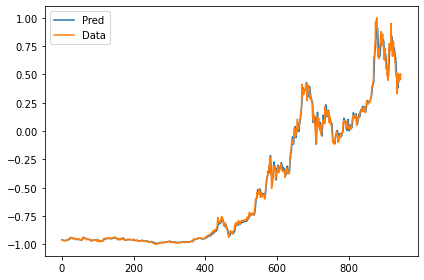

In [93]:
"训练集效果图"
# 无论是真实值，还是模型的输出值，它们的维度均为（batch_size, seq, 1），seq=20
# 我们的目的是用前20天的数据预测今天的股价，所以我们只需要每个数据序列中第20天的标签即可
# 因为前面用了使用DataFrame中shift方法，所以第20天的标签，实际上就是第21天的股价
pred_value = y_train_pred.detach().numpy()[:, -1, 0]
true_value = trainY.detach().numpy()[:, -1, 0]

plt.plot(pred_value, label="Pred")  # 预测值
plt.plot(true_value, label="Data")  # 真实值
plt.legend()
plt.tight_layout()

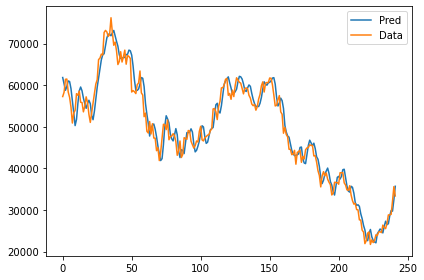

In [92]:
# 纵坐标还有负的，因为前面进行缩放，现在让数据还原成原来的大小
# invert predictions
pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.plot(pred_value, label="Pred")  # 预测值
plt.plot(true_value, label="Data")  # 真实值
plt.legend()
plt.tight_layout()

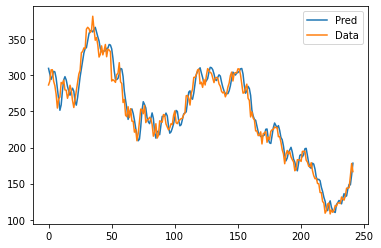

In [57]:
"测试集效果图"
pred_value = y_test_pred.detach().numpy()[:, -1, 0]
true_value = testY.detach().numpy()[:, -1, 0]

pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.plot(pred_value, label="Pred")  # 预测值
plt.plot(true_value, label="Data")  # 真实值
plt.legend()
plt.show()